In [1]:
import torch 
import os
import numpy as np
import scipy as sp
import scipy.io as sio
# import utils
from torch import nn
from torch.nn import functional as F
from torch import optim
from net.chemtools.PLS import PLS
#from net.base_net import CuiNet,DeepSpectraCNN,ResNet18_1D,ViT_1D,FullyConvNet
from net.base_net import CuiNet,FullyConvNet,CuiNetJCB1,CuiNetJCB3,CuiNetJCB4,CuiNetJCB1x10
from utils.testing import test                      # ligne rajoutée
from utils.testing import ccc,r2_score,RMSEP
import matplotlib.pyplot as plt
from utils.training import train
from utils.testing import test 
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split

# JC pour importer les fichiers tabulés
import numpy as np
import pandas as pd
import sys 

import math


2025-02-02 12:54:24.282113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738497264.563671    4106 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738497264.643077    4106 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 12:54:25.297061: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# un lien relatif permet de placer le répertoire Deep-chemometrics-jcb n'importe où sur le disque
local_path=os.getcwd() + '/data/rmn_196'

# la première ligne commentée est celle valable pour galaxy



# CHOIX DES DONNEES RMN ---------

# données alignées + 2101 valeurs (simufiltre)
local_path_xcal=local_path + '/xtrain_rmn.tab'
local_path_xtest=local_path + '/xtest_rmn.tab'

# données non alignées + 2101 valeurs (1/50)
#local_path_xcal=local_path + '/xcal_2101_nonaligne.tab'
#local_path_xtest=local_path+ '/xval_2101_nonaligne.tab'

# données non alignées + 105001 valeurs
#local_path_xcal=local_path + '/xcal_105001_nonaligne.tab'
#local_path_xtest=local_path + '/xval_105001_nonaligne.tab'

# ---------------------------------------



#X_train=pd.read_csv("${Xdata.file_name}", sep="\t", header=0)
Xcal=pd.read_csv(local_path_xcal, sep="\t", header=0)
Xcal.drop(Xcal.columns[0],axis=1,inplace=True)

#Y_train=pd.read_csv("${Ydata.file_name}", sep="\t", header=0)
local_path_ycal=local_path+'/ytrain_rmn.tab'
Ycal=pd.read_csv(local_path_ycal, sep="\t", header=0)

#X_test =pd.read_csv("${Xdata_val.file_name}", sep="\t", header=0)
Xtest=pd.read_csv(local_path_xtest, sep="\t", header=0)
Xtest.drop(Xtest.columns[0],axis=1,inplace=True)

#Y_test =pd.read_csv("${Xdata_val.file_name}", sep="\t", header=0)
local_path_ytest=local_path+'/ytest_rmn.tab'
Ytest=pd.read_csv(local_path_ytest, sep="\t", header=0)

## partie à décommenter pour galaxy
#Y_column=${Ycolumn}-1
#Y_column_val=${Ycolumn_val}-1   ## debut a 0

Ycal=Ycal.iloc[:,1:2]
Ytest=Ytest.iloc[:,1:2]

print(Xcal.shape)

(147, 2101)


In [3]:
# ----------------------------------------------------------------        JCB 22jan25
# ajustement de la dimension des matrices Xcat et Xtest 
# pour etre compatibles avec les valeurs de kernel_size et stride 
# ---------------------------------------------------------------


# definition des valeurs de kernel_size et stride  ----------
# pour la première couche de convolution 
# valeurs utilisées pour ajuster le nombre de variables en entrée 
# de manière à obtenir un nombre entier pour la première couche 
kernel_size=11
stride=5

# cuinetJC1
kernel_size0=kernel_size;
stride0=stride;

# pcuionetJC3
kernel_size1=kernel_size;
stride1=stride;


# -----------------------------------------------------------

# calcul du nombre de variables compatible avec k.size et stride 
q=Xcal.shape[1]      # q = nombre de variables du spectre RMN
n=(q-kernel_size)/stride
qnew=(math.floor(n))*stride + kernel_size
print(q)
print('qnew')
print(qnew)

# ajustement des nouvelles dimensions 
Xcal=Xcal.iloc[:,0:qnew]    # enleve -1
Xtest=Xtest.iloc[:,0:qnew]

input_dims=math.floor(n)+1;   

print(Xcal.shape)
print(Xtest.shape)
print(input_dims)

Ycal=np.squeeze(np.eye(2)[Ycal])
print(Ycal.shape)

2101
qnew
2101
(147, 2101)
(49, 2101)
419
(147, 2)


In [4]:
print("X and Y testing set")
print(Ytest.shape)
print("convert to one hot encoding")
Ytest = np.squeeze(np.eye(2)[Ytest])
print(Xtest.shape)
#print(Ytest.shape)

X and Y testing set
(49, 1)
convert to one hot encoding
(49, 2101)


In [ ]:
# PAS NECESSAIRE 


plt.figure(figsize=(10,6))

plt.subplot(221)
plt.title('Train data')
plt.plot(Xcal.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Deplacement chimique ppm')

plt.subplot(222)
plt.title('Test data')
plt.plot(Xtest.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Deplacement chimique ppm')

plt.subplot(223)
# plt.plot(data['DM_cal'])
plt.plot(Ycal.T)
plt.ylabel('syrah')
plt.xlabel('Sample number')

plt.subplot(224)
# plt.plot(data['DM_test'])
plt.plot(Ytest.T)
plt.ylabel('syrah')
plt.xlabel('Sample number')

plt.tight_layout()
plt.show()

In [5]:
## Spliting the train set 
x_cal, x_val, y_cal, y_val = train_test_split(Xcal, Ycal, test_size=0.20, shuffle=True, random_state=42) 

## The wavelenghts for the XX axis when we plot the spectra
# x_scale=data['wave'].astype(np.float32).reshape(-1,1)               data ne sert pas car fichier pas matlab

## Check for dimensions
print('Data set dimensions ----------------------------')
print('Full Train set dims X Y = {}\t{}'.format(Xcal.shape, Ycal.shape))
print('Calibration set dims X Y = {}\t{}'.format(x_cal.shape, y_cal.shape))
print('val set dims X Y = {}\t{}'.format(x_val.shape, y_val.shape))
print('Test set dims X Y = {}\t{}'.format(Xtest.shape, Ytest.shape))
# print('wavelengths number = {}'.format(np.shape(x_scale)))          pas data -> pas xscale

Data set dimensions ----------------------------
Full Train set dims X Y = (147, 2101)	(147, 2)
Calibration set dims X Y = (117, 2101)	(117, 2)
val set dims X Y = (30, 2101)	(30, 2)
Test set dims X Y = (49, 2101)	(49, 2)


In [ ]:
# PAS NECESSAIRE


## Visual data sanity checking for the test set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
# plt.plot(x_val[:50,:].T,'k')
plt.plot(x_val.T,'k')           # .T est la transposée

plt.title('First 50 spectra from the val sample')
plt.xlabel(r'ppm')
plt.ylabel('Spectra intensity')
plt.subplot(1,2,2)
plt.title('Y labels')
plt.plot(y_val,'k.')
plt.xlabel('Sample number')
plt.ylabel('syrah')
plt.show()

In [6]:
# calculate mean and std per column

mean = np.mean(x_cal, axis=0)
std = np.std(x_cal, axis=0)

# Convert np.array to Dataloader 

# JC conversion en np.array
x_cal=np.array(x_cal)
y_cal=np.array(y_cal)
x_val=np.array(x_val)
y_val=np.array(y_val)
Xtest=np.array(Xtest)
Ytest=np.array(Ytest)

print(x_cal.shape)
print(y_cal.shape)

cal = data_utils.TensorDataset(torch.Tensor(x_cal), torch.Tensor(y_cal))
cal_loader = data_utils.DataLoader(cal, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
val_loader = data_utils.DataLoader(val, batch_size=100, shuffle=True)

test_dt = data_utils.TensorDataset(torch.Tensor(Xtest), torch.Tensor(Ytest))
test_loader = data_utils.DataLoader(test_dt, batch_size=100, shuffle=True)


(117, 2101)
(117, 2)


In [ ]:
#CUINET

from net.base_net import CuiNet

# kernel_size et stride sont définis dans base_net.py / conv. layer 
# et écrasent les valeurs définies dans le script 
# kernel_size=5
# stride=1


print('kernel size')
print(kernel_size)
print('stride')
print(stride)
      


# define model parameters 

model_name ="_cuinet"  
spec_dims = x_cal.shape[1]
LR = 0.0001
num_epochs = 500
#save_interval = 10
out_dims=2
#weight_decay=0.003/2
dropout=0.1

# repertoire de sauvegarde 

save_path = local_path + f'/models/{model_name}/' + model_name
print(save_path)

# CuiNet est un modèle pré-défini 
model = CuiNet(spec_dims, mean,std,dropout,out_dims)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss(reduction='none')
criterion_test =  nn.BCEWithLogitsLoss(reduction='none')

print(model)
#CuiNet(
#  (conv1d): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
#  (fc1): Linear(in_features=614, out_features=36, bias=True)
#  (fc2): Linear(in_features=36, out_features=18, bias=True)
#  (fc3): Linear(in_features=18, out_features=12, bias=True)
#  (out): Linear(in_features=12, out_features=1, bias=True)
#)

train_losses, val_losses,metrics, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path,classification=True)

In [ ]:
# Cuinet      (kernel_size,stride)=(5,1)         accuracy=  0,76 - 0,61  0,65
#                                  (3,1)
test(model,final_path,test_loader,classification=True)



In [ ]:
# ------------
# FullyConvNet
# ------------

# attention: prédit 0 partout !!!

model_name="_FullyConvNet_OSSL"
spec_dims=x_cal.shape[1]
LR=0.0001
num_epochs=100
save_path=local_path  + f'/models/{model_name}/' + model_name

model=FullyConvNet(spec_dims,mean=mean, std=std,out_dims=2)
optimizer=optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion=nn.BCEWithLogitsLoss(reduction='none')
criterion_test=nn.BCEWithLogitsLoss(reduction='none')

print(model)

train_losses,val_losses,val_r2_scores,final_path=train(model,optimizer,criterion,cal_loader,val_loader,num_epochs,save_path=save_path,classification=True)

In [ ]:
#FullyConNet     accuracy=0,3   très mauvais 

print(model)

test(model,final_path,test_loader,classification=True)



In [ ]:
# ----------
# CuiNETJCB1
# ----------

# amélioration / CuiNet: les principaux paramètres ont été sortis des fonctions 
# ils sont maintenant regroupés et modifiables facilement 


# --------------------
# paramètres du modèle
# --------------------

kernel_size0=3
stride0=2



# classification ou régression? 
classification=True

# nombre de dimensions en entrée = nombre de variables des spectres 
spec_dims = x_cal.shape[1]

# nombre de dimensions en sortie 
out_dims=2       

# LR = learning rate = taux d'apprentissage 
# + petit => + lent => + adapté à de peits jeux de données 
LR = 0.005

# num_epochs = critère proche d'un nombre de répétitions 
num_epochs = 1000   # valeur très faible, juste pour faire tourner le modèlee; mettre 1000 ou plus 

# ?
save_interval = 10
dropout=0.1

# couche de convolution
# supprime car deja definis plus haut 
#kernel_size=13        # largeur de la fenetre glissante; un nombre impair 
#stride=5              # pas de déplacement de la fenetre glissante 

# --------------------------------------------
# attention BUG ne marche plus si stride>1 car la formule: dime. sortie convol. = dim. entrée - kernel_size + 1 ne marche plus !
# --------------------------------------------

# optimisation 
weight_decay=0.003/2

# sauvegarde des modèles  
model_name="_cuinetJCB1"
save_path = local_path + '/data/rmn_196/' + f'/models/{model_name}/' + model_name
print(save_path)

# finalisation de la configuration de CuiNetJCB1
model = CuiNetJCB1(spec_dims, mean,std, dropout, out_dims,kernel_size0,stride0)

# optimisation 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)

# 

# critères d'évaluation de la performance du modèle 
criterion = nn.BCEWithLogitsLoss(reduction='none')
criterion_test =  nn.BCEWithLogitsLoss(reduction='none')

print(model)

# -----------------------------------------
# lancement de la procédure d'apprentissage 
# -----------------------------------------
train_losses, val_losses,metrics, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval,classification=classification)

In [ ]:
# CuinetJCB1        (kernel_size,stride) = (11,5)   accuracy = 0,55  0,76  0,86  0,67  0,86
#                                        = (7,3)             = 0,76  0,71  0,90  0,94  0,76   bon +                                 
#                                        = (3,1)             = 0,73  0,69  0,71  0,80  0,63 
#                                        = (7,1)             = 0,71  0,73  0,73  0,86  0,76
#                                        = (9,3)             = 0,90  0,80  0,78  0,76  0,88   bon 
#                                        = (7,4)             = 0,94  0,86  0,71  0,80  0,82   bon +
#                                        = (8,3)             = 0,78  0,84  0,73  0,92  0,76   bon 
#                                        = (9,3)             = 0,63  0,51  0,49  0,51  0,71
#                                        = (7,5)             = 0,59  0,55  0,63  0,68  0,57
#                                        = (6,3)             = 0,55  0,57  0,59  0,78  0,63
#                                        = (7,3)             = 0,69  0,57 
#                                        = (3,2)             vloss=1,8             f1=0,60    accuracy=0,76
#                                        = (5,3)                   2,5                0,78             0,69
#                                        = (7,2)                   2                  0,75             0,71
#                                        = (7,4)                   2                  0,62             0,80
#                                        = (5,2)                   2                  0,60
#                                        = (9,3)                   2                  0,75             0,61
#                                        = (3,2)                   1,5                0,75             0,80
#                                        = (2,1)                   2,5                0,70             0,63
#                                        = (1,1)                   4                  0,70             0,65
#                                        = (3,2)                   1,2                0,75             0,86
#                                        = (4,2)                   3,5                0,80             0,71
#     LR=0,0001  avant                   = (3,2)                   1,4                0,70             0,49
#     LR=0,01                            = (3,2)                   1,5                0,75             0,80
#                                        = (3,2)                                      0,85             0,82                    
#     LR=0,1                             = (3,2)                                      0,75             0,63
#     LR=0,005                           = (3,2)                                      0,85             0,69
#       = 0,01                           = (4,2)                                      0,78             0,59
#       = 0,01                           = (3,2)                                      0,80             0,78

#  retenu: ()

print(model)

test(model,final_path,test_loader,classification=True)


/home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/models/_cuinetJCB1x10/_cuinetJCB1x10
CuiNetJCB1x10(
  (dropout): ManualDropout()
  (conv1d): Conv1d(1, 10, kernel_size=(3,), stride=(2,))
  (fc1): Linear(in_features=10500, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=2, bias=True)
)
Epoch 1/500 | Train Losses: y 0: 9.5129 | Validation Losses: y 0: 9.0428 | Metrics: F1 Score: 0.5667
Model saved at epoch 1 to /home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/models/_cuinetJCB1x10/_cuinetJCB1x10_best.pth


/home/pfp/Desktop/Deep-Chemometrics-jcb/net/base_net.py:229: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mean = nn.Parameter(torch.tensor(mean).float(),requires_grad=False)
/home/pfp/Desktop/Deep-Chemometrics-jcb/net/base_net.py:230: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.std = nn.Parameter(torch.tensor(std).float(),requires_grad=False)


Epoch 2/500 | Train Losses: y 0: 8.1393 | Validation Losses: y 0: 3.9216 | Metrics: F1 Score: 0.6333
Model saved at epoch 2 to /home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/models/_cuinetJCB1x10/_cuinetJCB1x10_best.pth
Epoch 3/500 | Train Losses: y 0: 3.7725 | Validation Losses: y 0: 3.5282 | Metrics: F1 Score: 0.6667
Model saved at epoch 3 to /home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/models/_cuinetJCB1x10/_cuinetJCB1x10_best.pth
Epoch 4/500 | Train Losses: y 0: 2.2783 | Validation Losses: y 0: 2.6173 | Metrics: F1 Score: 0.6667
Model saved at epoch 4 to /home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/models/_cuinetJCB1x10/_cuinetJCB1x10_best.pth
Epoch 5/500 | Train Losses: y 0: 1.8964 | Validation Losses: y 0: 2.1557 | Metrics: F1 Score: 0.6333
Model saved at epoch 5 to /home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/models/_cuinetJCB1x10/_cuinetJCB1x10_best.pth
Epoch 6/500 | Train Losses: y 0: 1.9251 | Validation Losses: y 0: 2.3133 | Metrics: F1 Score: 0.

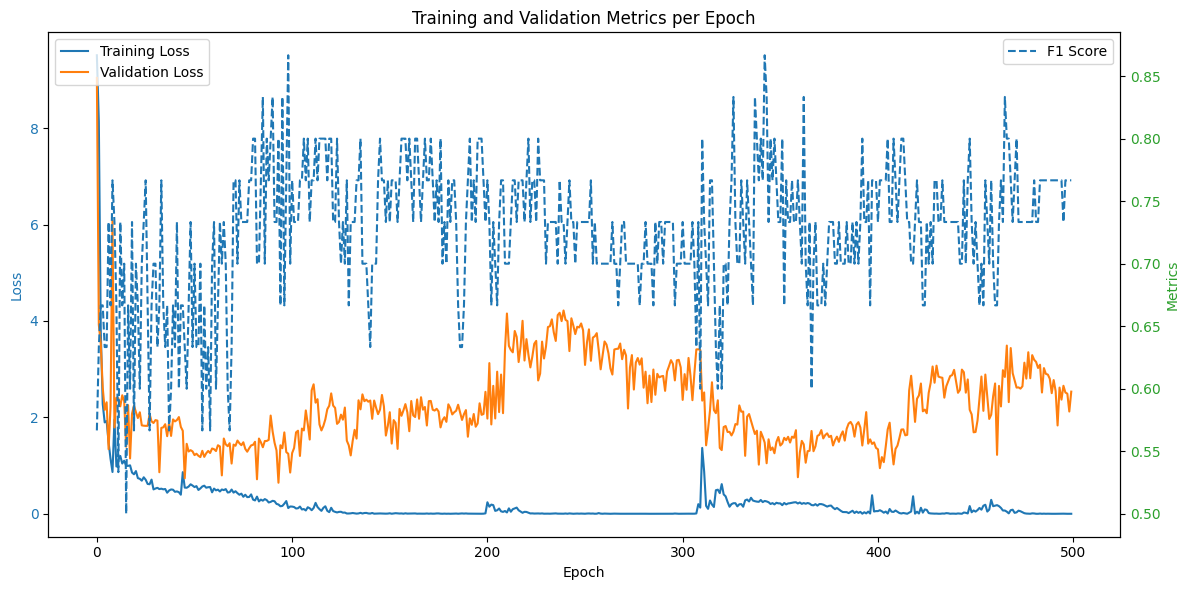

In [8]:
# -------------
# CuiNETJCB1x10
# -------------
# 10 répétitions 
# --------------

# --------------------
# paramètres du modèle
# --------------------
kernel_size0=3               # fenêtre de la couche de convolution
stride0=2                    # déplacement de la fenetre de convolution
classification=True          # True si classification
spec_dims = x_cal.shape[1]   # nbre dimensions en entrée = nbre de variables des spectres 
out_dims=2                   # nbre de dimensions en sortie, ici 2 car 2 classes     
LR = 0.01                    # learning rate = taux d'apprentissage 
num_epochs = 500             # nbre de fois où toutes les données ont été évaluées
save_interval = 10
dropout=0.1
weight_decay=0.003/2         # optimisation 
model_name="_cuinetJCB1x10"  # nom du modèle sauvegarde   
save_path = local_path + f'/models/{model_name}/' + model_name      # chemin complet du modèle 
print(save_path)

# -----------------------
# construction du modèle 
# -----------------------
model = CuiNetJCB1x10(spec_dims, mean,std, dropout, out_dims,kernel_size0,stride0)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss(reduction='none')                  # critères d'évaluation de la performance 
criterion_test =  nn.BCEWithLogitsLoss(reduction='none')
print(model)

# -----------------------------------------
# lancement de la procédure d'apprentissage 
# -----------------------------------------
train_losses, val_losses,metrics, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval,classification=classification)

In [11]:
# CuinetJCB1x10        

print(model)

test(model,final_path,test_loader,classification=True)


CuiNetJCB1x10(
  (dropout): ManualDropout()
  (conv1d): Conv1d(1, 10, kernel_size=(3,), stride=(2,))
  (fc1): Linear(in_features=10500, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=2, bias=True)
)
(49, 2)
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        31
           1       0.75      0.67      0.71        18

    accuracy                           0.80        49
   macro avg       0.78      0.77      0.77        49
weighted avg       0.79      0.80      0.79        49

[[27  4]
 [ 6 12]]


array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0])

In [ ]:
# ----------
# CuiNETJCB3
# ----------

# amélioration / CuiNetJCB1:  
# 2 couches de convolution, paramétrables pour kernel_size et stride de chaque couche de convolution 


# --------------------
# paramètres du modèle
# --------------------

# classification ou régression? 
classification=True

# nombre de dimensions en entrée = nombre de variables des spectres 
spec_dims = x_cal.shape[1]

# paramètres de la 2° couche de convolution 
kernel_size2=3
stride2=2

# nombre de dimensions en sortie 
out_dims=2    

# LR = learning rate = taux d'apprentissage 
# + petit => + lent => + adapté à de peits jeux de données 
LR = 0.0001

# num_epochs = critère proche d'un nombre de répétitions 
num_epochs = 100   # valeur très faible, juste pour faire tourner le modèlee; mettre 1000 ou plus 

#                                                                   que représentent ces 2 valeurs??
# save_interval = 10
dropout=0.1

# optimisation 
# weight_decay=0.003/2

# sauvegarde des modèles  
model_name="_cuinetJCB3"
save_path = local_path + f'/models/{model_name}/' + model_name
print(save_path)

# finalisation de la configuration de CuiNetJCB1
model = CuiNetJCB3(spec_dims, mean,std, dropout, out_dims,kernel_size1,stride1,kernel_size2,stride2)

# optimisation 
optimizer = optim.Adam(model.parameters(), lr=LR )

# critères d'évaluation de la performance du modèle 
criterion = nn.BCEWithLogitsLoss(reduction='none')
criterion_test =  nn.BCEWithLogitsLoss(reduction='none')

print(model)

# -----------------------------------------
# lancement de la procédure d'apprentissage 
# -----------------------------------------
train_losses, val_losses,metrics, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, classification=classification)

In [ ]:
# cuinetJCB3        (kernel_size,stride) = (11,5) (3,2)     accuracy = 0,67   0,65   0,59   0,55    0,61 
# moins bon que cuinet 
print(model)

test(model,final_path,test_loader,classification=True)





In [ ]:
# ----------
# CuiNETJCB4
# ----------

# amélioration / CuiNetJCB3:  
# ajustement des paramètres selon les indications de Maxime Metz


# --------------------
# paramètres du modèle
# --------------------

# classification ou régression? 
classification=True

# nombre de dimensions en entrée = nombre de variables des spectres 
spec_dims = x_cal.shape[1]

# paramètres de la 1° couche 
kernel_size1=5
stride1=2
# paramètres de la 2° couche de convolution 
kernel_size2=3
stride2=1

# nombre de dimensions en sortie 
out_dims=2    

# LR = learning rate = taux d'apprentissage 
# + petit => + lent => + adapté à de peits jeux de données 
LR = 0.0001                                                         # modifié

# num_epochs = critère proche d'un nombre de répétitions 
num_epochs = 500   # valeur très faible, juste pour faire tourner le modèlee; mettre 1000 ou plus 

#                                                          
dropout=0.1

# optimisation 
# weight_decay=0.003/2    @ supprimé; on travaille avec la valeur par défaut 

# sauvegarde des modèles  
model_name="_cuinetJCB4"
save_path = local_path + f'/models/{model_name}/' + model_name
print(save_path)

# finalisation de la configuration de CuiNetJCB1
model = CuiNetJCB4(spec_dims, mean,std, dropout, out_dims,kernel_size1,stride1,kernel_size2,stride2)

# optimisation 
optimizer = optim.Adam(model.parameters(), lr=LR )

# critères d'évaluation de la performance du modèle 
criterion = nn.BCEWithLogitsLoss(reduction='none')
criterion_test =  nn.BCEWithLogitsLoss(reduction='none')

print(model)
print(spec_dims)

# -----------------------------------------
# lancement de la procédure d'apprentissage 
# -----------------------------------------
train_losses, val_losses,metrics, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, classification=classification)

In [ ]:
# cuiNetJCB4 

print(model)

test(model,final_path,test_loader,classification=True)

#  (kernel_size,stride) = 1-2(11,5) + 2-4(3,2)         orange = 1,6  1000 epochs   f1 score = 0,70 
#                                                      orange = 1,6  1000 epochs   f1 score = 0,71 
#                       = 1-2(11,5)  + 2-4(3,1)         orange = 2,2                f1 score = 0,70
#                                                      orange = 2,2                f1 score = 0,60
#                       = 1-2(7,3)  + 2-4(5,1)         orange = 2,0                f1 score = 0,56
#                                                      orange = 2                  f1 score = 0,8 
#                       = 1-2(9,5)  + 2-4(5,3)         orange = 1      400 epochs   f1 score = 0,75          
#                            (7,3)        (3,1)        orange = 2,5                 f1 score = 0,72
#                            (11,7)       (7,5)        orange = 0,60                f1 score = 0,80
#                                                      orange = 1                   f1 score = 0,65
#                                                      orange = 1      500 epochs   f1 score = 0,75
#                            (13,5)       (9,3)        orange = 1,5                 f1 score = 0,7
#                            (11,7)       (5,3)        orange = 1,5                 f1 score = 0,65 
#                            (13,7)       (7,3)        orange = 1                   f1 score = 0,75 
#                            (13,7)       (7,5)        orange = 1                   f1 score = 0,75
#                            (11,7)       (7,5)        orange = 2                   f1 score = 0,55
#                            (11,7)       (7,5)        orange = 1,2                 f1 score = 0,75      accuracy = 0,65
#                            (5,2)        (3,1)               = 4                              0,75                 0,63